# Deep Networks: Hands‑on Notebook

Each section matches your slide list. All cells run fast on CPU, use only NumPy and Matplotlib by default. Optional PyTorch cells will auto‑disable if PyTorch/torchvision are unavailable or datasets cannot be downloaded.

Run cells in order.

In [1]:

# Minimal dependencies
import numpy as np
import matplotlib.pyplot as plt
import math, time
np.random.seed(42)
print("NumPy", np.__version__)


NumPy 2.2.6


## What is a deep network?
A deep network composes linear maps and nonlinear activations. Example: 
$f(x)=W_L\,\phi(\cdots \phi(W_2\,\phi(W_1 x + b_1)+b_2)\cdots)+b_L$. We build and run a tiny 3‑layer MLP on synthetic data.

Output shape: (1, 200)


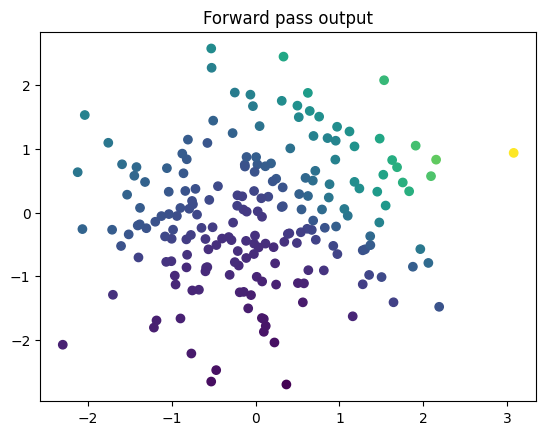

In [2]:

# Tiny MLP forward example
def relu(x): return np.maximum(0, x)
def init_layer(m, n): 
    return {'W': np.random.randn(m, n)*0.1, 'b': np.zeros((m,1))}

def mlp_forward(x, layers):
    cache = {'A0': x}
    A = x
    for i,layer in enumerate(layers[:-1], start=1):
        Z = layer['W'] @ A + layer['b']
        A = relu(Z)
        cache[f'Z{i}'], cache[f'A{i}'] = Z, A
    # last linear layer (regression)
    L = layers[-1]
    out = L['W'] @ A + L['b']
    cache[f'Z{len(layers)}'], cache[f'A{len(layers)}'] = out, out
    return out, cache

layers = [init_layer(16,2), init_layer(16,16), init_layer(1,16)]
# toy 2D input
x = np.random.randn(2, 200)
y = (x[0:1,:]**2 + x[1:2,:] > 0.5).astype(float)  # non-linear label
pred, cache = mlp_forward(x, layers)
print("Output shape:", pred.shape)
plt.figure(); plt.scatter(x[0], x[1], c=pred.ravel()); plt.title("Forward pass output"); plt.show()


## Composition and expressivity
Depth composes simple transforms to model complex functions. We approximate an XNOR decision boundary.

In [ ]:

# Train a 2-layer ReLU MLP to fit XNOR pattern quickly with simple gradient descent
def mse_loss(pred, y):
    diff = pred - y
    return 0.5*np.mean(diff**2), diff/ pred.shape[1]

def mlp_backward(cache, layers, dOut):
    grads = []
    A_prev = cache['A0']
    dA = dOut
    L = len(layers)
    for l in range(L, 0, -1):
        Zl = cache[f'Z{l}']
        Al_1 = cache[f'A{l-1}'] if l>1 else cache['A0']
        Wl = layers[l-1]['W']
        if l != L: # hidden layer: ReLU
            dA = dA * (Zl>0)
        dW = dA @ Al_1.T / dOut.shape[1]
        db = np.mean(dA, axis=1, keepdims=True)
        grads.append((l-1, dW, db))
        dA = Wl.T @ dA
    return grads[::-1]

# Make XNOR dataset
N = 400
X = (np.random.rand(2,N)>0.5).astype(float)*2-1
Y = ((X[0]==X[1]).astype(float)).reshape(1,N)

layers = [init_layer(8,2), init_layer(8,8), init_layer(1,8)]
lr=0.5
for t in range(200):
    pred, cache = mlp_forward(X, layers)
    loss, dOut = mse_loss(pred, Y)
    grads = mlp_backward(cache, layers, dOut)
    for idx,dW,db in grads:
        layers[idx]['W'] -= lr*dW
        layers[idx]['b'] -= lr*db
    if (t+1)%50==0:
        print(f"step {t+1}, loss={loss:.4f}")
plt.figure(); plt.scatter(X[0], X[1], c=pred.ravel()>0.5); plt.title("XNOR learned"); plt.show()


## Activations and gradients
Compare sigmoid, tanh, ReLU effects on gradient flow.

In [ ]:

def sigmoid(x): return 1/(1+np.exp(-x))
def tanh(x): return np.tanh(x)

xs = np.linspace(-6,6,400)
plt.figure(); plt.plot(xs, sigmoid(xs)); plt.plot(xs, tanh(xs)); plt.plot(xs, np.maximum(0,xs)); plt.title("Activations"); plt.legend(['sigmoid','tanh','ReLU']); plt.show()

# gradient magnitude across layers for random deep nets
def grad_mag(activation, L=20, trials=50):
    mags=[]
    for _ in range(trials):
        x = np.random.randn(100,1)
        g = np.ones_like(x)
        for l in range(L):
            W = np.random.randn(100,100)/np.sqrt(100)
            x = W@x
            if activation=='relu':
                g = (x>0)*g
                x = np.maximum(0,x)
            elif activation=='tanh':
                g = (1-np.tanh(x)**2)*g
                x = np.tanh(x)
            else:
                s = sigmoid(x)
                g = (s*(1-s))*g
                x = s
        mags.append(np.mean(np.abs(g)))
    return np.mean(mags)

for act in ['sigmoid','tanh','relu']:
    print(act, "avg grad mag (L=20):", grad_mag(act))


## Initialization basics
He (ReLU) and Xavier/Glorot balance variance across layers.

In [ ]:

def var_after_layers(fan_in, fan_out, nonlin='relu', scheme='he'):
    if scheme=='he': std=np.sqrt(2/fan_in)
    elif scheme=='xavier': std=np.sqrt(1/(fan_in))
    else: std=0.1
    W = np.random.randn(fan_out, fan_in)*std
    x = np.random.randn(fan_in, 1000)
    y = W@x
    if nonlin=='relu': y = np.maximum(0,y)
    return np.var(y)

for scheme in ['he','xavier','plain']:
    print(scheme, "var:", var_after_layers(512,512,'relu',scheme))


## Regularization toolkit
L2 weight decay, dropout, early stopping. We demo L2 and dropout on synthetic data.

In [ ]:

def dropout(A, p=0.8, train=True):
    if not train: return A, np.ones_like(A)
    mask = (np.random.rand(*A.shape) < p)/p
    return A*mask, mask

# One epoch with L2 and dropout
def train_epoch(X, Y, layers, lr=0.1, l2=1e-3, pdrop=0.8):
    # forward with dropout on hidden layers
    cache={'A0':X}
    A = X
    dropmasks=[]
    for i,layer in enumerate(layers[:-1], start=1):
        Z = layer['W'] @ A + layer['b']
        A = np.maximum(0,Z)
        A,mask = dropout(A, pdrop, train=True)
        dropmasks.append(mask)
        cache[f'Z{i}'], cache[f'A{i}'] = Z, A
    L = layers[-1]
    out = L['W'] @ A + L['b']
    cache[f'Z{len(layers)}'], cache[f'A{len(layers)}'] = out, out

    loss, dOut = mse_loss(out,Y)
    # L2
    loss += 0.5*l2*sum([np.sum(Li['W']**2) for Li in layers])
    grads = []
    dA = dOut
    for l in range(len(layers),0,-1):
        Zl = cache[f'Z{l}']
        Al_1 = cache[f'A{l-1}'] if l>1 else cache['A0']
        Wl = layers[l-1]['W']
        if l != len(layers): 
            dA = dA * (Zl>0)
            dA = dA * dropmasks[l-2]
        dW = dA @ Al_1.T / X.shape[1] + l2*Wl
        db = np.mean(dA, axis=1, keepdims=True)
        grads.append((l-1, dW, db))
        dA = Wl.T @ dA
    for idx,dW,db in grads[::-1]:
        layers[idx]['W'] -= lr*dW
        layers[idx]['b'] -= lr*db
    return loss

# quick run
X = np.random.randn(2,256); Y = (X[0:1]**2+X[1:1+1]>1).astype(float)
layers = [init_layer(32,2), init_layer(32,32), init_layer(1,32)]
hist=[]
for t in range(60):
    hist.append(train_epoch(X,Y,layers, lr=0.2, l2=1e-3, pdrop=0.8))
plt.figure(); plt.plot(hist); plt.title("Loss with L2 + Dropout"); plt.show()


## Objective and minibatching
We implement minibatch SGD for binary cross‑entropy.

In [ ]:

def bce_loss(logits, y):
    # logits to prob via sigmoid
    p = 1/(1+np.exp(-logits))
    eps=1e-8
    loss = -np.mean(y*np.log(p+eps)+(1-y)*np.log(1-p+eps))
    dlogits = (p - y)/y.shape[1]
    return loss, dlogits

def train_minibatch(X, Y, layers, batch=64, lr=0.1, steps=200):
    n = X.shape[1]; losses=[]
    for t in range(steps):
        idx = np.random.choice(n, size=min(batch,n), replace=False)
        x = X[:,idx]; y = Y[:,idx]
        out, cache = mlp_forward(x, layers)
        loss, dOut = bce_loss(out, y)
        grads = mlp_backward(cache, layers, dOut)
        for idx,dW,db in grads:
            layers[idx]['W'] -= lr*dW
            layers[idx]['b'] -= lr*db
        losses.append(loss)
    return losses

X = np.random.randn(2,512); Y = (X[0:1]*X[1:2]>0).astype(float)
layers = [init_layer(16,2), init_layer(16,16), init_layer(1,16)]
losses = train_minibatch(X,Y,layers, batch=64, lr=0.2, steps=200)
plt.figure(); plt.plot(losses); plt.title("Minibatch SGD, BCE"); plt.show()


## Optimizer zoo
SGD, Momentum, RMSProp, Adam. We optimize a simple non‑convex function.

In [ ]:

def rosenbrock(X,Y,a=1,b=100):
    return (a-X)**2 + b*(Y-X**2)**2

def grad_rosenbrock(x,y,a=1,b=100):
    dx = -2*(a-x) - 4*b*x*(y-x**2)
    dy = 2*b*(y-x**2)
    return dx, dy

def optimize(opt='sgd', steps=500, lr=1e-3):
    x,y = -1.2, 1.0
    vx=vy=0; sx=sy=0; mx=my=0; t=0
    traj=[]
    for i in range(steps):
        t+=1
        dx,dy = grad_rosenbrock(x,y)
        if opt=='sgd':
            x-=lr*dx; y-=lr*dy
        elif opt=='momentum':
            beta=0.9; vx=beta*vx+(1-beta)*dx; vy=beta*vy+(1-beta)*dy
            x-=lr*vx; y-=lr*vy
        elif opt=='rmsprop':
            beta=0.99; sx=beta*sx+(1-beta)*dx*dx; sy=beta*sy+(1-beta)*dy*dy
            x-=lr*dx/np.sqrt(sx+1e-8); y-=lr*dy/np.sqrt(sy+1e-8)
        elif opt=='adam':
            b1,b2=0.9,0.999
            mx=b1*mx+(1-b1)*dx; my=b1*my+(1-b1)*dy
            sx=b2*sx+(1-b2)*dx*dx; sy=b2*sy+(1-b2)*dy*dy
            mxc=mx/(1-b1**t); myc=my/(1-b1**t)
            sxc=sx/(1-b2**t); syc=sy/(1-b2**t)
            x-=lr*mxc/np.sqrt(sxc+1e-8); y-=lr*myc/np.sqrt(syc+1e-8)
        traj.append((x,y))
    return np.array(traj)

opts=['sgd','momentum','rmsprop','adam']
for o in opts:
    tr = optimize(o, steps=800, lr=1e-3 if o!='adam' else 2e-3)
    plt.figure()
    Xs = np.linspace(-2,2,200); Ys=np.linspace(-1,3,200)
    XX,YY = np.meshgrid(Xs,Ys); ZZ = rosenbrock(XX,YY)
    cs = plt.contour(XX,YY,ZZ, levels=20)
    plt.plot(tr[:,0], tr[:,1])
    plt.title(f"Trajectory: {o}")
    plt.show()


## LR schedules and warmup
Cosine decay with linear warmup on a toy loss.

In [ ]:

def lr_schedule(t, T=200, base=0.2, warm=20):
    if t < warm: return base*(t+1)/warm
    # cosine decay to 5% of base
    rem = T - warm
    tt = min(max(t-warm,0), rem)
    return 0.05*base + 0.95*base*0.5*(1+np.cos(np.pi*tt/rem))

L = [lr_schedule(t) for t in range(200)]
plt.figure(); plt.plot(L); plt.title("Warmup + Cosine LR"); plt.show()


## Batch size and clipping
Demonstrate gradient norm clipping and batch size effect on noise.

In [ ]:

def grad_norm(grads):
    return np.sqrt(sum([np.sum(g[1]**2)+np.sum(g[2]**2) for g in grads]))
def step_with_clip(layers, grads, lr, clip=1.0):
    gnorm = grad_norm(grads)
    scale = min(1.0, clip/(gnorm+1e-8))
    for idx,dW,db in grads:
        layers[idx]['W'] -= lr*(dW*scale)
        layers[idx]['b'] -= lr*(db*scale)
    return gnorm

# Compare batch sizes
X = np.random.randn(2,2048); Y=(X[0:1]*X[1:2]>0).astype(float)
layers = [init_layer(32,2), init_layer(32,32), init_layer(1,32)]
hist_small=[]; hist_large=[]
for t in range(100):
    idx = np.random.choice(X.shape[1], 32, replace=False)
    out, cache = mlp_forward(X[:,idx], layers)
    loss, dOut = bce_loss(out, Y[:,idx])
    grads = mlp_backward(cache, layers, dOut)
    hist_small.append(step_with_clip(layers, grads, lr=0.3, clip=1.0))

    idx = np.random.choice(X.shape[1], 512, replace=False)
    out, cache = mlp_forward(X[:,idx], layers)
    loss, dOut = bce_loss(out, Y[:,idx])
    grads = mlp_backward(cache, layers, dOut)
    hist_large.append(step_with_clip(layers, grads, lr=0.3, clip=1.0))

plt.figure(); plt.plot(hist_small, label="batch=32"); plt.plot(hist_large, label="batch=512"); plt.legend(); plt.title("Gradient norms vs batch size"); plt.show()


## Loss landscapes
Visualize a 2D slice of MLP parameter space.

In [ ]:

# Freeze a trained model, sweep along two random directions in parameter space
def pack_params(layers):
    flat=[]
    for L in layers: flat.append(L['W'].ravel()); flat.append(L['b'].ravel())
    return np.concatenate(flat)
def unpack_params(theta, layers):
    pos=0
    for L in layers:
        szw = L['W'].size; szb=L['b'].size
        L['W'] = theta[pos:pos+szw].reshape(L['W'].shape); pos+=szw
        L['b'] = theta[pos:pos+szb].reshape(L['b'].shape); pos+=szb
    return layers

# train quick model
X = np.random.randn(2,256); Y=(X[0:1]+X[1:2]>0).astype(float)
layers = [init_layer(8,2), init_layer(8,8), init_layer(1,8)]
for t in range(100):
    out, cache = mlp_forward(X, layers)
    loss, dOut = bce_loss(out,Y)
    grads = mlp_backward(cache, layers, dOut)
    for idx,dW,db in grads:
        layers[idx]['W'] -= 0.2*dW
        layers[idx]['b'] -= 0.2*db

theta0 = pack_params(layers).copy()
d1 = np.random.randn(theta0.size); d2 = np.random.randn(theta0.size)
d1 /= np.linalg.norm(d1)+1e-8; d2 /= np.linalg.norm(d2)+1e-8

alphas = np.linspace(-2,2,40); betas = np.linspace(-2,2,40)
Z = np.zeros((len(alphas), len(betas)))
for i,a in enumerate(alphas):
    for j,b in enumerate(betas):
        th = theta0 + a*d1 + b*d2
        # copy layers structure
        layers_s = [ {'W':L['W'].copy(), 'b':L['b'].copy()} for L in layers ]
        unpack_params(th, layers_s)
        out,_ = mlp_forward(X, layers_s)
        Z[i,j],_ = bce_loss(out,Y)
plt.figure()
cs=plt.contourf(alphas, betas, Z.T, levels=20)
plt.title("Loss landscape slice"); plt.show()


## Chain rule graph
We compute forward and backward using a computation graph with caches.

In [ ]:

# Simple linear -> ReLU -> linear block with explicit caches
def linear_forward(A,W,b):
    Z = W@A + b; cache=(A,W,b); return Z, cache
def linear_backward(dZ, cache):
    A,W,b = cache
    m=A.shape[1]
    dW = dZ@A.T/m; db=np.mean(dZ,axis=1,keepdims=True); dA=W.T@dZ
    return dA, dW, db

def relu_forward(Z): return np.maximum(0,Z), Z
def relu_backward(dA, cacheZ): return dA*(cacheZ>0)

# End-to-end demo
np.random.seed(0)
A0 = np.random.randn(4,10)
W1,b1 = np.random.randn(6,4)*0.1, np.zeros((6,1))
W2,b2 = np.random.randn(1,6)*0.1, np.zeros((1,1))
Z1,c1 = linear_forward(A0,W1,b1)
A1,c1a = relu_forward(Z1)
Z2,c2 = linear_forward(A1,W2,b2)
Y = (np.random.rand(1,10)>0.5).astype(float)
loss, dZ2 = bce_loss(Z2,Y)  # using logits
dA1,dW2,db2 = linear_backward(dZ2,c2)
dZ1 = relu_backward(dA1,c1a)
dA0,dW1,db1 = linear_backward(dZ1,c1)
print("Grad shapes:", dW1.shape, db1.shape, dW2.shape, db2.shape)


## Linear‑activation backward
We already separated `linear_backward` and `relu_backward` above.

## Gradient formulas and cache
Gradients came from chain rule: $\frac{\partial L}{\partial W}=\frac{\partial L}{\partial Z}\frac{\partial Z}{\partial W}$, cache stores $(A,W,b)$ and $Z$.

## Gradient checking
Validate backprop using finite differences.

In [ ]:

def numgrad(param_selector, loss_fn, eps=1e-5):
    base = param_selector().copy()
    grad = np.zeros_like(base)
    it = np.nditer(base, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        val = base[idx]
        param_selector()[idx]=val+eps
        l1 = loss_fn()
        param_selector()[idx]=val-eps
        l2 = loss_fn()
        grad[idx]=(l1-l2)/(2*eps)
        param_selector()[idx]=val
        it.iternext()
    return grad

# Check dW1 for small network above
W1_ref = W1.copy()
def sel_W1(): 
    global W1; return W1
def compute_loss():
    Z1,_ = linear_forward(A0,W1,b1)
    A1,_ = relu_forward(Z1)
    Z2,_ = linear_forward(A1,W2,b2)
    return bce_loss(Z2,Y)[0]

# analytical dW1 from previous cell variables
dW1_analytic = dW1.copy()
dW1_numerical = numgrad(sel_W1, compute_loss)
print("||diff||:", np.linalg.norm(dW1_analytic - dW1_numerical))


## Convolution mechanics
Naive NumPy 2D convolution for a single image and multi‑channel kernels.

In [ ]:

def conv2d_naive(x, w, b=0, stride=1, pad=0):
    # x: (C,H,W), w: (F,C,KH,KW)
    C,H,W = x.shape; F,_,KH,KW = w.shape
    Hout = (H + 2*pad - KH)//stride + 1
    Wout = (W + 2*pad - KW)//stride + 1
    xp = np.pad(x, ((0,0),(pad,pad),(pad,pad)))
    y = np.zeros((F,Hout,Wout))
    for f in range(F):
        for i in range(Hout):
            for j in range(Wout):
                hs, ws = i*stride, j*stride
                window = xp[:, hs:hs+KH, ws:ws+KW]
                y[f,i,j] = np.sum(window * w[f]) + b
    return y

x = np.random.randn(3, 8, 8)
w = np.random.randn(4, 3, 3, 3)*0.1
y = conv2d_naive(x,w, b=0.0, stride=2, pad=1)
print("Output shape (F,H,W):", y.shape)


## Padding/stride and sizes
$H_{out}=\left\lfloor\frac{H+2P-K}{S}\right\rfloor+1$, similar for width. We verify numerically.

In [ ]:

def out_size(H,W,K,S,P):
    Hout=(H+2*P-K)//S+1
    Wout=(W+2*P-K)//S+1
    return Hout,Wout

for (H,W,K,S,P) in [(32,32,3,1,1),(32,32,5,2,2),(7,7,3,2,0)]:
    print((H,W,K,S,P), "->", out_size(H,W,K,S,P))


## Receptive field and parameter counts
Receptive field grows with layers. For stride‑1 convs: $r_{l}=r_{l-1}+ (k_l-1)\prod_{i<l}s_i$. Parameters per conv: $F\times C\times K\times K$. We compute a quick example.

In [ ]:

def receptive_field(kernels, strides):
    r=1; j=1 # r: receptive field size, j: jump
    for k,s in zip(kernels, strides):
        r = r + (k-1)*j
        j = j*s
    return r

kernels=[3,3,3]; strides=[1,1,2]
print("Receptive field:", receptive_field(kernels,strides))
F,C,K = 64, 32, 3
params = F*C*K*K
print("Params for conv:", params)


## Modern CNN blocks
Residual block: $y= x + \mathrm{ConvBNReLU}(\mathrm{ConvBN}(x))$. Depthwise separable: depthwise KxK then pointwise 1x1 to cut params from $F\cdot C\cdot K^2$ to $(C\cdot K^2)+(C\cdot F)$.
Below is a NumPy forward for a tiny residual block using our naive conv.

In [ ]:

def relu_img(x): return np.maximum(0,x)
def conv_block(x, Cin, Cout, K=3):
    w = np.random.randn(Cout, Cin, K, K)*0.05
    y = conv2d_naive(x, w, stride=1, pad=K//2)
    return relu_img(y)

def residual_block(x, C):
    out = conv_block(x, C, C)
    out = conv_block(out, C, C)
    return relu_img(out + x)

x = np.random.randn(16,16,16)  # C,H,W
y = residual_block(x, 16)
print("Residual block output:", y.shape)


## CIFAR‑10 demo results
Attempt to train a tiny CNN using PyTorch if available; fall back to a quick MLP on sklearn digits if not.

In [ ]:

import importlib, warnings
def try_cifar10():
    torch_avail = importlib.util.find_spec("torch") is not None and importlib.util.find_spec("torchvision") is not None
    if not torch_avail:
        print("PyTorch/torchvision not available. Falling back to sklearn digits MLP demo.")
        return False
    import torch, torch.nn as nn, torch.optim as optim
    import torchvision
    import torchvision.transforms as T
    try:
        transform = T.Compose([T.ToTensor()])
        train = torchvision.datasets.CIFAR10(root="/mnt/data/cifar", download=True, train=True, transform=transform)
        test = torchvision.datasets.CIFAR10(root="/mnt/data/cifar", download=True, train=False, transform=transform)
    except Exception as e:
        print("CIFAR download failed:", e)
        return False
    trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(test, batch_size=256, shuffle=False, num_workers=0)
    class Tiny(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Conv2d(3,32,3,padding=1), nn.ReLU(),
                nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(64,128,3,padding=1), nn.ReLU(),
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(128,10)
            )
        def forward(self,x): return self.net(x)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model=Tiny().to(device)
    opt=optim.Adam(model.parameters(), lr=1e-3)
    crit=nn.CrossEntropyLoss()
    # very short train for demo
    model.train()
    for i,(x,y) in enumerate(trainloader):
        x,y=x.to(device), y.to(device)
        opt.zero_grad(); out=model(x); loss=crit(out,y); loss.backward(); opt.step()
        if i==50: break
    # eval
    model.eval(); correct=total=0
    with torch.no_grad():
        for x,y in testloader:
            x,y=x.to(device), y.to(device)
            out=model(x); pred=out.argmax(1)
            correct += (pred==y).sum().item(); total += y.numel()
    print(f"CIFAR-10 demo accuracy (very short run): {correct/total:.3f}")
    return True

ok = try_cifar10()
if not ok:
    # fallback: sklearn digits
    try:
        from sklearn.datasets import load_digits
        from sklearn.model_selection import train_test_split
        from sklearn.neural_network import MLPClassifier
        data = load_digits()
        X = data.data/16.0; y=data.target
        Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.3,random_state=42)
        clf = MLPClassifier(hidden_layer_sizes=(64,64), max_iter=200, random_state=42)
        clf.fit(Xtr,ytr)
        acc = clf.score(Xte,yte)
        print("Digits MLP accuracy:", acc)
    except Exception as e:
        print("Fallback demo failed:", e)


## Summary and pitfalls
- Depth composes simple parts for complex functions.
- ReLU + He init helps gradient flow.
- Regularize with weight decay, dropout, early stopping.
- Use minibatch SGD and well‑chosen optimizers and LR schedules.
- Clip gradients for stability.
- Validate backprop with gradient checking.
- For CNNs, track shapes, receptive field, and parameters.
- Common pitfalls: bad init, wrong learning rate, no normalization, shape mismatches, silent broadcasting bugs.